In [1]:
!pip install tensorflow
!pip show tensorflow


Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/conda/lib/python3.11/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [2]:
import pandas as pd
from io import StringIO
from torchvision.transforms import Compose, ToTensor, Lambda,Resize
import torch
import numpy as np
import tensorflow as tf
from enum import Enum
import torch.nn.functional as F

2024-09-07 20:32:22.330610: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-07 20:32:22.344923: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-07 20:32:22.349301: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-07 20:32:22.362099: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-07 20:32:23.131310: W tensorflow/compiler/tf2

In [3]:
import os
print(os.getcwd())

/home/jovyan/work/diffusion/src


In [4]:
df_dataset_description = pd.read_csv("/home/jovyan/work/handout/extended-gkd-dataset/gkd-dataset/dataset-index.csv")
df_dataset_description

filepath  image_kind  \
0      unlabeled/2023_01_24_12_39_39_733_DC0.tiff_0_0...           0   
1      unlabeled/2023_01_24_12_39_39_733_DC0.tiff_0_1...           0   
2      unlabeled/2023_01_24_12_39_39_733_DC0.tiff_0_2...           0   
3      unlabeled/2023_01_24_12_39_39_733_DC0.tiff_0_3...           0   
4      unlabeled/2023_01_24_12_39_39_733_DC0.tiff_0_4...           0   
...                                                  ...         ...   
35611  labeled-IO/2023_01_06_12_42_28_980_DC2.tiff_0_...           5   
35612  labeled-IO/2023_01_06_12_42_28_980_DC2.tiff_0_...           5   
35613  labeled-IO/2023_01_06_12_42_28_980_DC2.tiff_0_...           5   
35614  labeled-IO/2023_01_06_12_42_28_980_DC2.tiff_0_...           5   
35615  labeled-IO/2023_01_06_12_42_28_980_DC2.tiff_0_...           5   

                    original_image_name  x   y  
0      2023_01_24_12_39_39_733_DC0.tiff  0   0  
1      2023_01_24_12_39_39_733_DC0.tiff  0   1  
2      2023_01_24_12_39_39_733_DC0.tiff  0   2  
3      2023_01_24_12_39_39_733_DC0.tiff  0   3  
4      2023_01_24_12_39_39_733_DC0.tiff  0   4  
...                                 ... ..  ..  
35611  2023_01_06_12_42_28_980_DC2.tiff  0   9  
35612  2023_01_06_12_42_28_980_DC2.tiff  0  10  
35613  2023_01_06_12_42_28_980_DC2.tiff  0  11  
35614  2023_01_06_12_42_28_980_DC2.tiff  0  12  
35615  2023_01_06_12_42_28_980_DC2.tiff  0  13  

[35616 rows x 5 columns]

In [5]:
class GkdImageSlice:
    def __init__(self, file_path, x: int, y: int, data: np.ndarray):
        self.file_path = file_path
        self.data = data
        self.x = x
        self.y = y

class GkdImageKind(Enum):
    UNLABELED_DC0=0
    NIO_DC0=1
    UNLABELED_DC2=2
    NIO_DC2=3
    LABELED_IO_DC0=4
    LABELED_IO_DC2=5

In [6]:
class GkdDataSequence(tf.keras.utils.Sequence):
    def __init__(self, path, image_kind: GkdImageKind, batch_size, shuffle=True):
        super().__init__()
        self.path = path
        self.image_kind = image_kind
        
        df = pd.read_csv(self.path+"/dataset-index.csv")
        self.dataset_index = df[df["image_kind"]==self.image_kind.value].reset_index(drop=True)        
        #if self.image_kind == "unlabeled":
            #self.dataset_index =df[df["filepath"].str.startswith("unlabeled")].reset_index(drop=True)
        #elif self.image_kind == "NIO":
            #self.dataset_index =df[df["filepath"].str.startswith("NIO")].reset_index(drop=True)
            
        self.batch_size = batch_size
        self.shuffle=shuffle
        self.indexes = np.arange(len(self.dataset_index.index))
        self.on_epoch_end()
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.floor(len(self.dataset_index.index)/self.batch_size))
    
    def __getitem__(self, batch_index):      
        # Generate data for the batch
        start_idx = batch_index * self.batch_size
        end_idx = (batch_index + 1) * self.batch_size
        batch_indexes = self.indexes[start_idx:end_idx]
        X, y = self.__data_generation(batch_indexes)

        """I am returning X two times here, since my example model
        is an Auto Encoder. In some cases this might not be what you want,
        so maybe try using y here after converting it to something usable
        torch.from_numpy
        """
        return torch.from_numpy(np.asarray(X)/8191)

    def __data_generation(self, batch_index):
        self.dataset_index.loc[batch_index]["filepath"]
        X = [np.fromfile("/home/jovyan/work/handout/extended-gkd-dataset/gkd-dataset/"+path, dtype=np.float32).reshape(512, 512) for path in self.dataset_index.loc[batch_index]["filepath"]]
        y = self.dataset_index.loc[batch_index][["original_image_name", "x", "y"]].reset_index(drop=True)
        return X, y

In [7]:
gkd_dataset= GkdDataSequence(path="/home/jovyan/work/handout/extended-gkd-dataset/gkd-dataset", batch_size=14,image_kind=GkdImageKind.UNLABELED_DC0, shuffle=False)

In [8]:
gkd_testdataset= GkdDataSequence(path="/home/jovyan/work/handout/extended-gkd-dataset/gkd-dataset", batch_size=14,image_kind=GkdImageKind.NIO_DC0, shuffle=False)

In [9]:
print(gkd_dataset.dataset_index["filepath"].head())

0    unlabeled/2023_01_24_12_39_39_733_DC0.tiff_0_0...
1    unlabeled/2023_01_24_12_39_39_733_DC0.tiff_0_1...
2    unlabeled/2023_01_24_12_39_39_733_DC0.tiff_0_2...
3    unlabeled/2023_01_24_12_39_39_733_DC0.tiff_0_3...
4    unlabeled/2023_01_24_12_39_39_733_DC0.tiff_0_4...
Name: filepath, dtype: object


In [10]:
print(gkd_testdataset.dataset_index["filepath"].iloc[2])

NIO/2023_01_17_04_25_24_276_DC0_Gewebe_und_Naht_und_BeginnHülse_und_Hülse.tiff_0_2.dat


In [11]:
num_samples = len(gkd_testdataset.dataset_index)
print(f"Number of samples: {num_samples}")
num_batches = len(gkd_testdataset)
print(f"Number of batches per epoch: {num_batches}")


Number of samples: 3360
Number of batches per epoch: 240


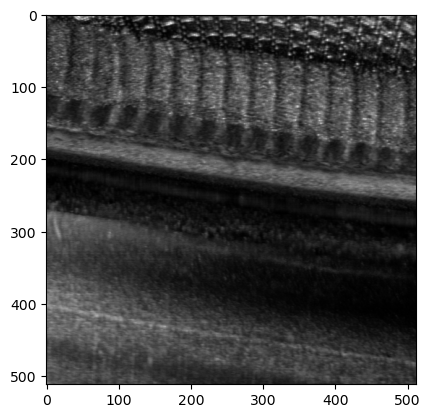

In [126]:
from matplotlib import pyplot as plt
for i in range(13):
    plt.imshow(gkd_testdataset[0][12], cmap="grey")

In [13]:

x=gkd_dataset[0]
print(x.shape)
a=x[0:2]
print(a.shape)
b=torch.unsqueeze(a,dim=1) 
print(b.shape)
c=torch.unsqueeze(b,dim=0) 
print(c.shape)
print(x.shape)
print(isinstance(x, np.ndarray))  # Output: True

torch.Size([14, 512, 512])
torch.Size([2, 512, 512])
torch.Size([2, 1, 512, 512])
torch.Size([1, 2, 1, 512, 512])
torch.Size([14, 512, 512])
False


In [14]:
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from pathlib import Path

from model.unet import UNet
from scheduler.ddpm import DDPMPipeline
#from scheduler.ddpm import DDPMPipeline
from utils.common import postprocess, create_images_grid
from config.train import training_config

torch.Size([14, 512, 512])
torch.Size([14, 1, 512, 512])
torch.Size([14, 1, 256, 256])


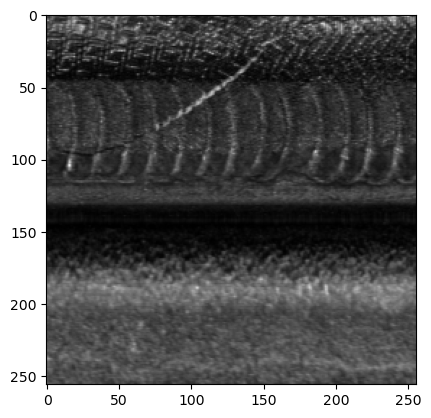

In [15]:

print(gkd_testdataset[1].shape)  # Should print torch.Size([14, 512, 512])

test_batch = gkd_testdataset[1].unsqueeze(1)
print(test_batch.shape)  # Should print torch.Size([14, 1, 512, 512])
test_batch=F.interpolate(test_batch, scale_factor = 0.5, mode='bilinear')
print(test_batch.shape)  # Should print torch.Size([14, 1, 256, 256])
plt.imshow(test_batch[3][0], cmap="grey")
test_batch =test_batch.to(training_config.device)

torch.Size([14, 1, 256, 256])


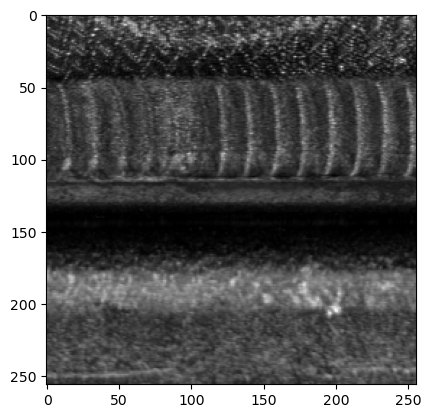

In [16]:
e=gkd_dataset[0]
f=torch.unsqueeze(e,dim=1)
g=F.interpolate(f, scale_factor = 0.5, mode='bilinear')
print(g.shape)
plt.imshow(g[0][0], cmap="grey")

In [17]:

print(torch.cuda.is_available())

True


In [18]:
"""for step in range(1):
    batch=gkd_dataset[step]
    images=torch.unsqueeze(batch,dim=1)
    original_images = images.to(training_config.device)
    batch_size = original_images.shape[0]
    print(original_images)
    """
"""
for step, batch in enumerate(gkd_dataset):
     if step<0: 
         original_images = batch.to(training_config.device)
         batch_size = original_images.shape
         if step%999==0:
             print(original_images)
     else:
         break
"""

'\nfor step, batch in enumerate(gkd_dataset):\n     if step<0: \n         original_images = batch.to(training_config.device)\n         batch_size = original_images.shape\n         if step%999==0:\n             print(original_images)\n     else:\n         break\n'

In [36]:
def evaluate(data,config, epoch, pipeline, model):
    # Perform reverse diffusion process with noisy images.
    """
    noisy_sample = torch.randn(
        config.eval_batch_size,
        config.image_channels,
        config.image_size,
        config.image_size).to(config.device)
    """
    
    # Reverse diffusion for T timesteps
    images = pipeline.sampling(model, data, device=config.device)
    """
    # Postprocess and save sampled images
    images = postprocess(images)
    images_squeezed=np.squeeze(images,axis=3)
    image_grid = create_images_grid(images_squeezed, rows=1, cols=14)

    grid_save_dir = Path(config.output_dir, "testsamp")
    grid_save_dir.mkdir(parents=True, exist_ok=True)
    image_grid.save(f"{grid_save_dir}/{epoch:04d}.png")
    """
    return images

In [20]:
def display_forward (images,config,epoch):

    # Postprocess and save sampled images
    images = postprocess(images)
    images_squeezed=np.squeeze(images,axis=3)
    image_grid = create_images_grid(images_squeezed, rows=1, cols=14)

    grid_save_dir = Path(config.output_dir, "forward")
    grid_save_dir.mkdir(parents=True, exist_ok=True)
    image_grid.save(f"{grid_save_dir}/{epoch:04d}.png")


In [21]:
train_dataloader = gkd_dataset
model = UNet(image_size=training_config.image_size,
             input_channels=training_config.image_channels).to(training_config.device)
print("Model size: ", sum([p.numel() for p in model.parameters() if p.requires_grad]))
optimizer = torch.optim.Adam(model.parameters(), lr=training_config.learning_rate)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,
                                                          T_max=len(train_dataloader) * training_config.num_epochs,
                                                          last_epoch=-1,
                                                          eta_min=1e-9)

Model size:  58654209


In [22]:
if training_config.resume:
    checkpoint = torch.load(training_config.resume, map_location='cpu')
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    training_config.start_epoch = checkpoint['epoch'] + 1
for param_group in optimizer.param_groups:
    param_group['lr'] = training_config.learning_rate
    
diffusion_pipeline = DDPMPipeline(beta_start=training_config.beta_start, beta_end=training_config.beta_end,
                                  num_timesteps=training_config.diffusion_timesteps)

global_step = training_config.start_epoch * len(train_dataloader)

In [23]:

# Initialize variables to track best model
best_mean_loss = float('inf')
best_epoch = -1
# Training loop
for epoch in range(training_config.start_epoch, training_config.num_epochs):
    progress_bar = tqdm(total=training_config.batch_num) 
    progress_bar.set_description(f"Epoch {epoch}")


    mean_loss = 0

    model.train()
   
    for step in range(training_config.batch_num): 
        
        batch=train_dataloader[step] 
        first_batch=batch
        
        #first_batch=torch.unsqueeze(first_batch,dim=0) 
        
        image=torch.unsqueeze(first_batch,dim=1) 
        
        images=F.interpolate(image, scale_factor = 0.5, mode='bilinear')
        
        original_images =images.to(training_config.device)
        batch_size = original_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(0, diffusion_pipeline.num_timesteps, (batch_size,),
                                  device=training_config.device).long()
        
        #timesteps = torch.full((batch_size,), 9, device=training_config.device).long()
            
        # Apply forward diffusion process at the given timestep
        noisy_images, noise = diffusion_pipeline.forward_diffusion(original_images, timesteps)
        
    
        #noisy_images = noisy_images.to(training_config.device)
        timesteps = timesteps.to(training_config.device)
        noise = noise.to(training_config.device)
        
        # Predict the noise residual
        noise_pred = model(noisy_images, timesteps)
        loss = F.mse_loss(noise_pred, noise)
        # Calculate new mean on the run without accumulating all the values
        mean_loss = mean_loss + (loss.detach().item() - mean_loss) / (step + 1)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        progress_bar.set_postfix(loss=f"{mean_loss:.4f}", lr=f"{lr_scheduler.get_last_lr()[0]:.2e}", step=global_step)
        #logs = {"loss": mean_loss, "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
        #progress_bar.set_postfix(**logs)
        global_step += 1
        
    progress_bar.close()
    print(f"Epoch {epoch} completed. Mean loss: {mean_loss:.4f}, LR: {lr_scheduler.get_last_lr()[0]:.2e}, Global step: {global_step}")

    
    """
    if (epoch+1) % 6==0:
        display_forward(noisy_images,training_config,epoch)
    """
    """
    copy_images = postprocess(copy)
    images_squeezed=np.squeeze(copy_images,axis=3)
    image_grid = create_images_grid(images_squeezed, rows=1, cols=14)
    grid_save_dir = Path(training_config.output_dir, "samples")
    grid_save_dir.mkdir(parents=True, exist_ok=True)
    image_grid.save(f"{grid_save_dir}/{epoch:04d}.png")
    """
    
    if mean_loss < best_mean_loss:
        best_mean_loss = mean_loss
        best_epoch = epoch
        checkpoint = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'parameters': training_config,
            'epoch': epoch,
            'mean_loss': mean_loss
        }
        torch.save(checkpoint, Path(training_config.output_dir, f"unet{training_config.image_size}_best.pth"))
        print(f"New best model saved at epoch {epoch} with mean loss: {mean_loss:.4f}")
    
    if (epoch+1) % 5 ==0:
        evaluation=original_images
    # Evaluation
    if (epoch + 1) % training_config.save_image_epochs == 0 or epoch == training_config.num_epochs - 1:
        
        timesteps = torch.randint(0, diffusion_pipeline.num_timesteps, (batch_size,),
        device=training_config.device).long()
        
        noisy_images, noise = diffusion_pipeline.forward_diffusion(evaluation, timesteps)
        noisy_images = noisy_images.to(training_config.device)
        timesteps = timesteps.to(training_config.device)
        noised=noisy_images

        def load_best_model(config, model):
            best_model_path = Path(config.output_dir, f"unet{config.image_size}_best.pth")
            if best_model_path.exists():
                checkpoint = torch.load(best_model_path, map_location=config.device)
                model.load_state_dict(checkpoint['model'])
                print(f"Loaded best model from epoch {checkpoint['epoch']} with mean loss: {checkpoint['mean_loss']:.4f}")
            else:
                print("Best model not found. Using current model state.")
            return model

        # Before evaluation
        model = load_best_model(training_config, model)
        
        model.eval()
        evaluate(noised,training_config, epoch, diffusion_pipeline, model)
    
    if (epoch + 1) % training_config.save_model_epochs == 0 or epoch == training_config.num_epochs-1 :
        checkpoint = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'parameters': training_config,
            'epoch': epoch,
            'mean_loss': mean_loss
        }
        torch.save(checkpoint, Path(training_config.output_dir,
                                    f"unet{training_config.image_size}_e{epoch}.pth"))
     


Epoch 0: 100%|██████████| 1000/1000 [10:35<00:00,  1.57it/s, loss=0.3344, lr=2.00e-05, step=999]


Epoch 0 completed. Mean loss: 0.3344, LR: 2.00e-05, Global step: 1000
New best model saved at epoch 0 with mean loss: 0.3344


Epoch 1: 100%|██████████| 1000/1000 [10:34<00:00,  1.57it/s, loss=0.1996, lr=2.00e-05, step=1999]


Epoch 1 completed. Mean loss: 0.1996, LR: 2.00e-05, Global step: 2000
New best model saved at epoch 1 with mean loss: 0.1996


Epoch 2: 100%|██████████| 1000/1000 [10:35<00:00,  1.57it/s, loss=0.1831, lr=2.00e-05, step=2999]


Epoch 2 completed. Mean loss: 0.1831, LR: 2.00e-05, Global step: 3000
New best model saved at epoch 2 with mean loss: 0.1831


Epoch 3: 100%|██████████| 1000/1000 [10:35<00:00,  1.57it/s, loss=0.1717, lr=1.99e-05, step=3999]


Epoch 3 completed. Mean loss: 0.1717, LR: 1.99e-05, Global step: 4000
New best model saved at epoch 3 with mean loss: 0.1717


Epoch 4: 100%|██████████| 1000/1000 [10:35<00:00,  1.57it/s, loss=0.1614, lr=1.99e-05, step=4999]


Epoch 4 completed. Mean loss: 0.1614, LR: 1.99e-05, Global step: 5000
New best model saved at epoch 4 with mean loss: 0.1614


Epoch 5: 100%|██████████| 1000/1000 [10:34<00:00,  1.57it/s, loss=0.1552, lr=1.98e-05, step=5999]


Epoch 5 completed. Mean loss: 0.1552, LR: 1.98e-05, Global step: 6000
New best model saved at epoch 5 with mean loss: 0.1552
Loaded best model from epoch 5 with mean loss: 0.1552


Epoch 6: 100%|██████████| 1000/1000 [10:34<00:00,  1.58it/s, loss=0.1526, lr=1.98e-05, step=6999]


Epoch 6 completed. Mean loss: 0.1526, LR: 1.98e-05, Global step: 7000
New best model saved at epoch 6 with mean loss: 0.1526


Epoch 7: 100%|██████████| 1000/1000 [10:34<00:00,  1.58it/s, loss=0.1478, lr=1.97e-05, step=7999]


Epoch 7 completed. Mean loss: 0.1478, LR: 1.97e-05, Global step: 8000
New best model saved at epoch 7 with mean loss: 0.1478


Epoch 8: 100%|██████████| 1000/1000 [10:34<00:00,  1.58it/s, loss=0.1470, lr=1.96e-05, step=8999]


Epoch 8 completed. Mean loss: 0.1470, LR: 1.96e-05, Global step: 9000
New best model saved at epoch 8 with mean loss: 0.1470


Epoch 9: 100%|██████████| 1000/1000 [10:34<00:00,  1.58it/s, loss=0.1442, lr=1.95e-05, step=9999]


Epoch 9 completed. Mean loss: 0.1442, LR: 1.95e-05, Global step: 10000
New best model saved at epoch 9 with mean loss: 0.1442


Epoch 10: 100%|██████████| 1000/1000 [10:33<00:00,  1.58it/s, loss=0.1453, lr=1.94e-05, step=10999]


Epoch 10 completed. Mean loss: 0.1453, LR: 1.94e-05, Global step: 11000


Epoch 11: 100%|██████████| 1000/1000 [10:33<00:00,  1.58it/s, loss=0.1420, lr=1.93e-05, step=11999]


Epoch 11 completed. Mean loss: 0.1420, LR: 1.93e-05, Global step: 12000
New best model saved at epoch 11 with mean loss: 0.1420
Loaded best model from epoch 11 with mean loss: 0.1420


Epoch 12: 100%|██████████| 1000/1000 [10:34<00:00,  1.58it/s, loss=0.1431, lr=1.92e-05, step=12999]


Epoch 12 completed. Mean loss: 0.1431, LR: 1.92e-05, Global step: 13000


Epoch 13: 100%|██████████| 1000/1000 [10:34<00:00,  1.58it/s, loss=0.1423, lr=1.90e-05, step=13999]


Epoch 13 completed. Mean loss: 0.1423, LR: 1.90e-05, Global step: 14000


Epoch 14: 100%|██████████| 1000/1000 [10:34<00:00,  1.58it/s, loss=0.1443, lr=1.89e-05, step=14999]


Epoch 14 completed. Mean loss: 0.1443, LR: 1.89e-05, Global step: 15000


Epoch 15: 100%|██████████| 1000/1000 [10:34<00:00,  1.58it/s, loss=0.1410, lr=1.88e-05, step=15999]


Epoch 15 completed. Mean loss: 0.1410, LR: 1.88e-05, Global step: 16000
New best model saved at epoch 15 with mean loss: 0.1410


Epoch 16: 100%|██████████| 1000/1000 [10:34<00:00,  1.58it/s, loss=0.1391, lr=1.86e-05, step=16999]


Epoch 16 completed. Mean loss: 0.1391, LR: 1.86e-05, Global step: 17000
New best model saved at epoch 16 with mean loss: 0.1391


Epoch 17: 100%|██████████| 1000/1000 [10:34<00:00,  1.58it/s, loss=0.1393, lr=1.84e-05, step=17999]


Epoch 17 completed. Mean loss: 0.1393, LR: 1.84e-05, Global step: 18000
Loaded best model from epoch 16 with mean loss: 0.1391


Epoch 18: 100%|██████████| 1000/1000 [10:34<00:00,  1.58it/s, loss=0.1410, lr=1.83e-05, step=18999]


Epoch 18 completed. Mean loss: 0.1410, LR: 1.83e-05, Global step: 19000


Epoch 19: 100%|██████████| 1000/1000 [10:34<00:00,  1.58it/s, loss=0.1398, lr=1.81e-05, step=2e+4]


Epoch 19 completed. Mean loss: 0.1398, LR: 1.81e-05, Global step: 20000


Epoch 20: 100%|██████████| 1000/1000 [10:34<00:00,  1.58it/s, loss=0.1378, lr=1.79e-05, step=20999]


Epoch 20 completed. Mean loss: 0.1378, LR: 1.79e-05, Global step: 21000
New best model saved at epoch 20 with mean loss: 0.1378


Epoch 21:  29%|██▊       | 286/1000 [03:01<07:34,  1.57it/s, loss=0.1413, lr=1.78e-05, step=21285]

KeyboardInterrupt: 

In [141]:
timesteps = torch.full((training_config.eval_batch_size,),0, device=training_config.device).long()

noisy_images, noise = diffusion_pipeline.forward_diffusion(test_batch, timesteps)
noisy_images = noisy_images.to(training_config.device)
timesteps = timesteps.to(training_config.device)
noised=noisy_images
display_forward(noised,training_config,0)

In [136]:
#timesteps = torch.randint(0, diffusion_pipeline.num_timesteps, (batch_size,),
#device=training_config.device).long()
timesteps = torch.full((training_config.eval_batch_size,),700, device=training_config.device).long()

noisy_images, noise = diffusion_pipeline.forward_diffusion(test_batch, timesteps)
noisy_images = noisy_images.to(training_config.device)
timesteps = timesteps.to(training_config.device)
noised=noisy_images
display_forward(noised,training_config,training_config.num_epochs)
def load_best_model(config, model):
    best_model_path = Path(config.output_dir, f"unet{config.image_size}_best.pth")
    if best_model_path.exists():
        checkpoint = torch.load(best_model_path, map_location=config.device)
        model.load_state_dict(checkpoint['model'])
        print(checkpoint.keys())
        print(f"Loaded best model from epoch {checkpoint['epoch']}")
    else:
        print("Best model not found. Using current model state.")
    return model

# Before evaluation
model = load_best_model(training_config, model)

model.eval()
reconstructed_images=evaluate(noised,training_config, training_config.num_epochs, diffusion_pipeline, model)


dict_keys(['model', 'optimizer', 'lr_scheduler', 'parameters', 'epoch', 'mean_loss'])
Loaded best model from epoch 20


100%|██████████| 800/800 [03:07<00:00,  4.28it/s]


In [137]:
#reconstructed_images=torch.from_numpy(reconstructed_images)
display_forward(reconstructed_images,training_config,training_config.num_epochs)

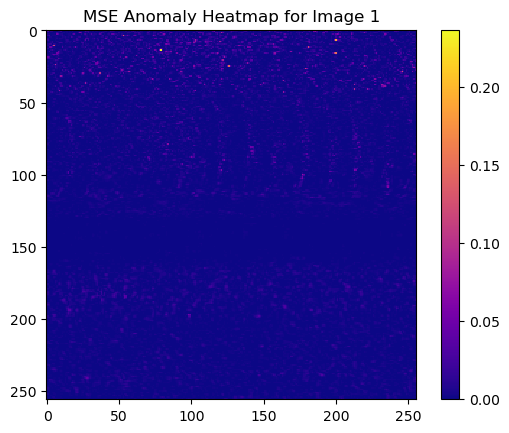

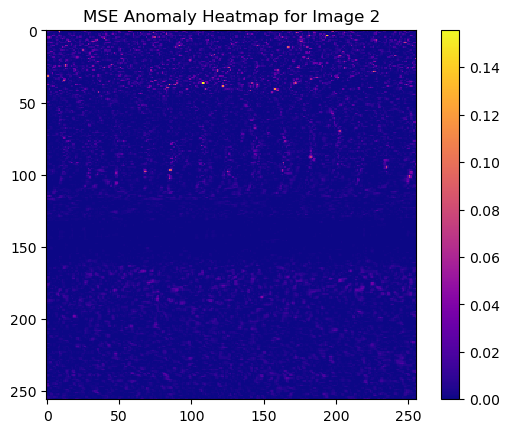

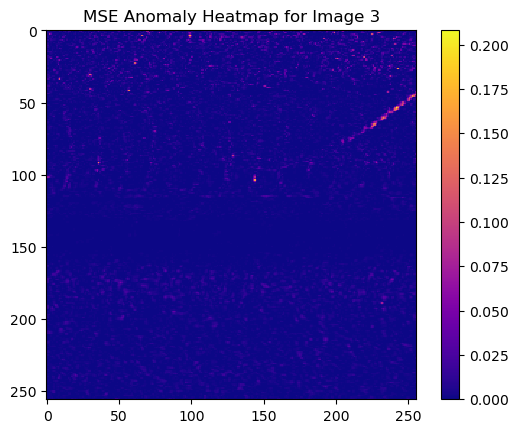

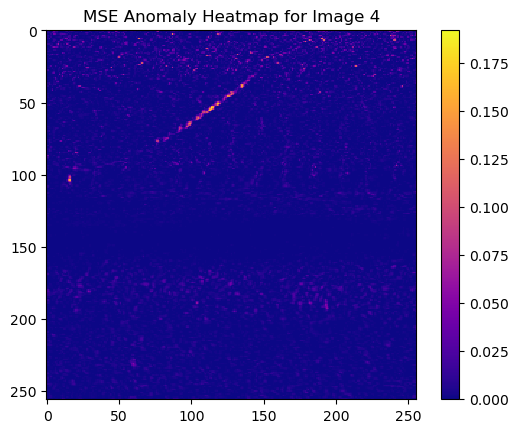

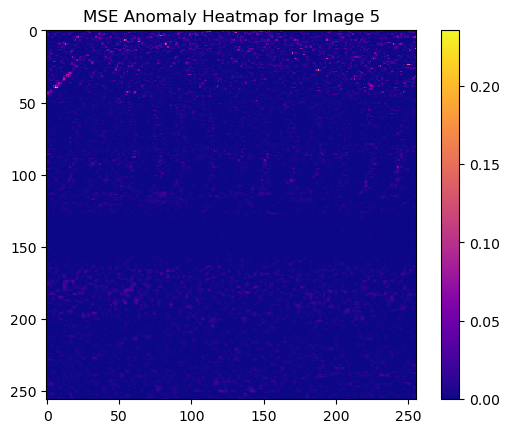

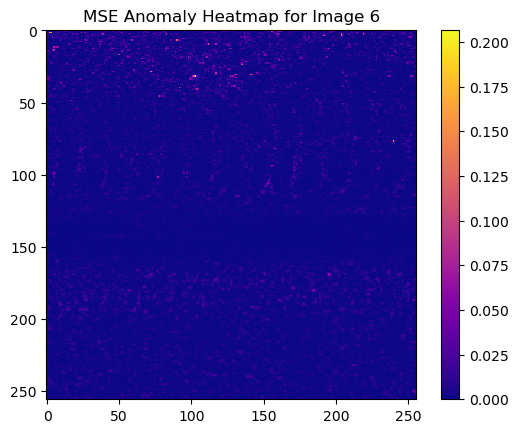

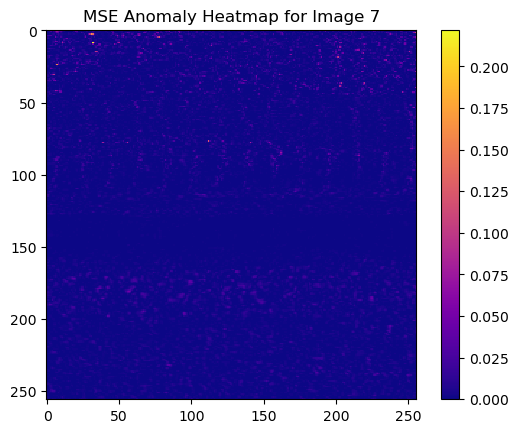

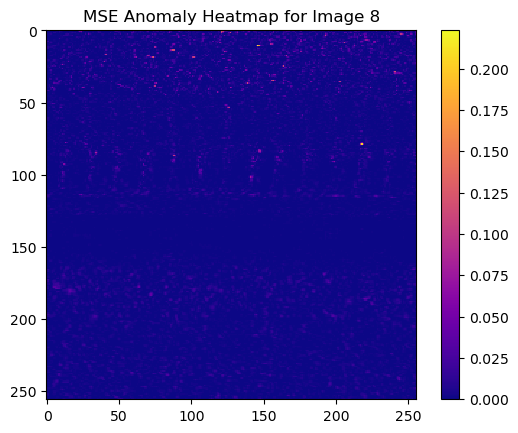

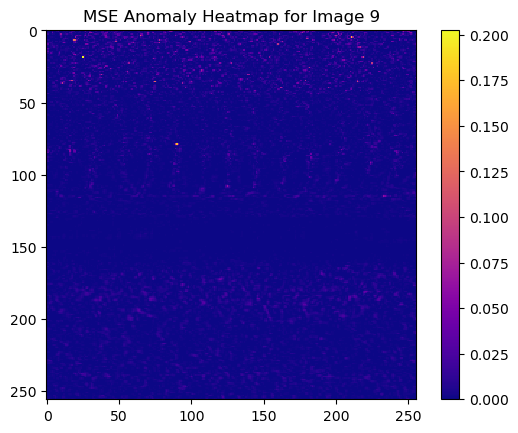

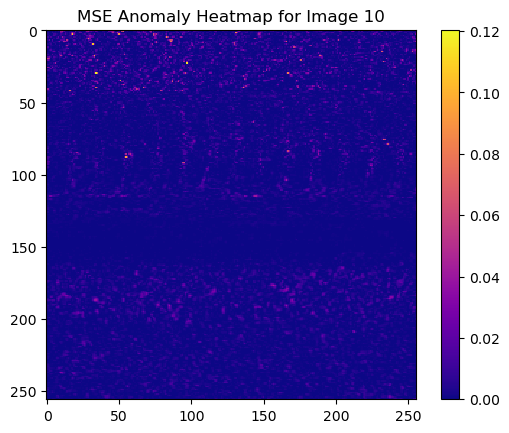

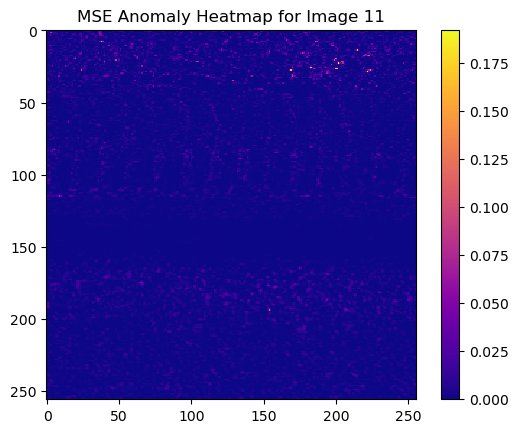

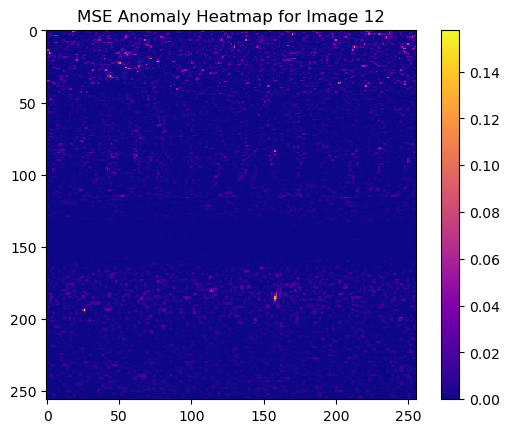

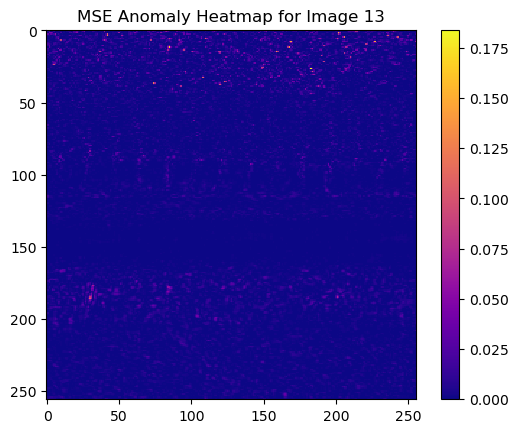

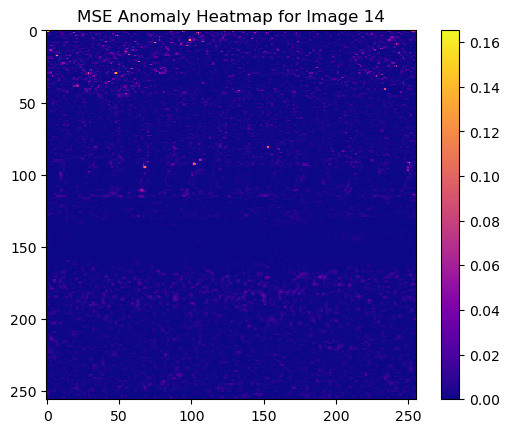

In [52]:

# Assuming test_batch and reconstructed_images are your two batches
# Compute the pixel-wise MSE (difference squared)
mse_difference = torch.square(test_batch - reconstructed_images)
def create_heatmap(mse_image):
    # Remove the channel dimension and convert to numpy
    mse_image = mse_image.squeeze(0).cpu().numpy()
    
    # Create a figure and axis
    fig, ax = plt.subplots()
    
    # Create the heatmap using a colormap like 'plasma'
    im = ax.imshow(mse_image, cmap='plasma', interpolation='nearest')
    
    # Add a colorbar
    plt.colorbar(im)
    
    return fig

# Create and display MSE heatmaps for all 14 image pairs
for i in range(14):
    fig = create_heatmap(mse_difference[i])
    plt.title(f'MSE Anomaly Heatmap for Image {i+1}')
    plt.show()

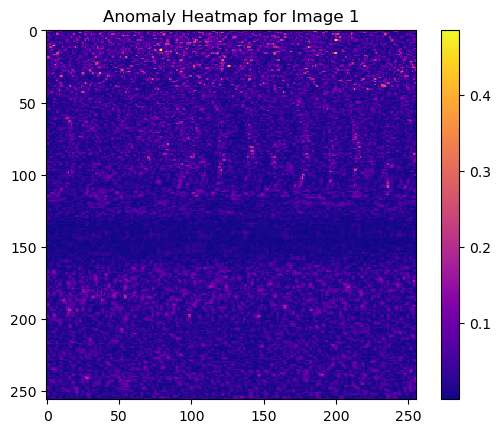

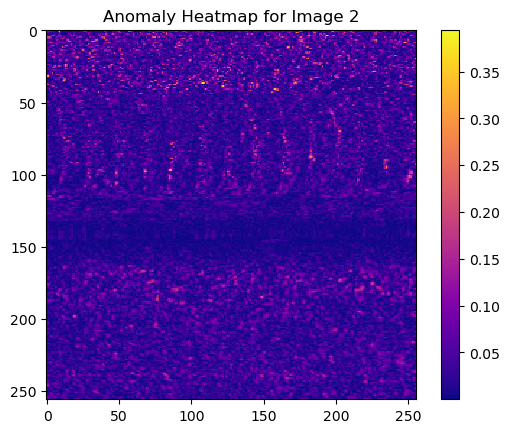

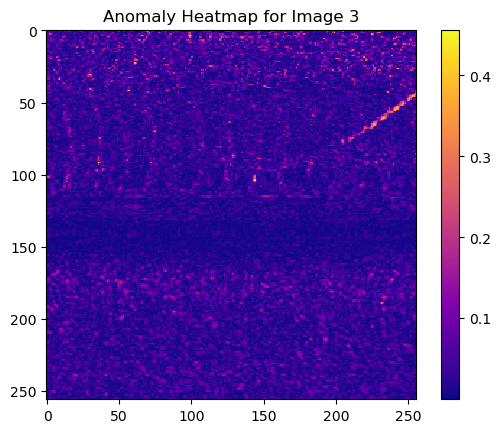

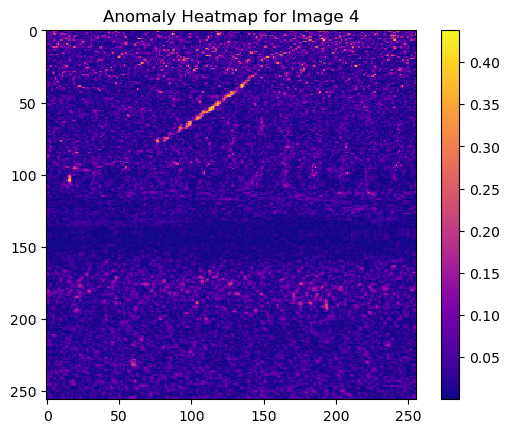

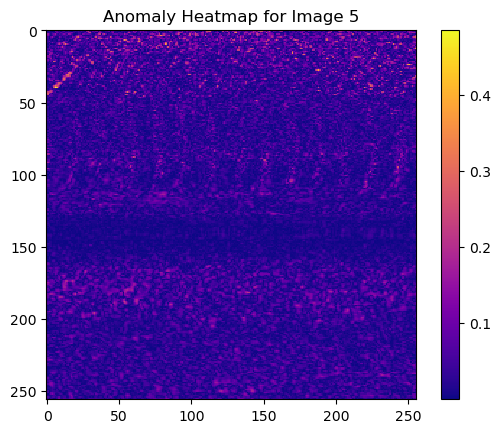

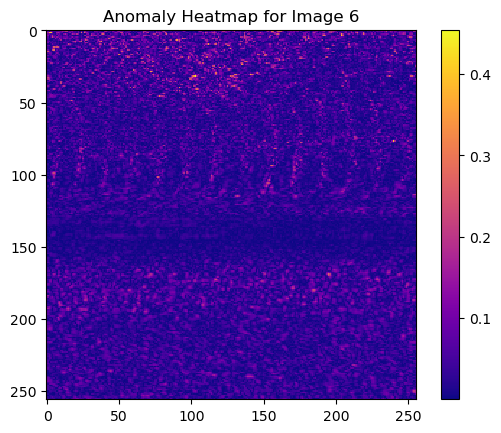

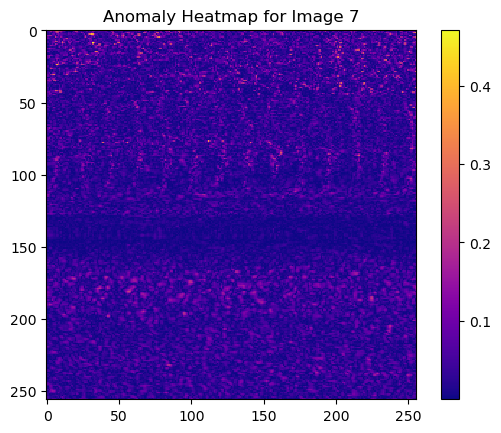

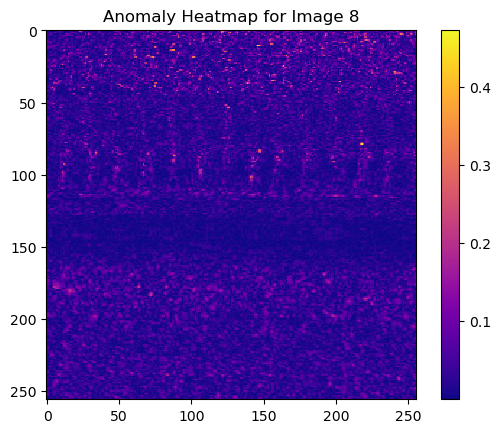

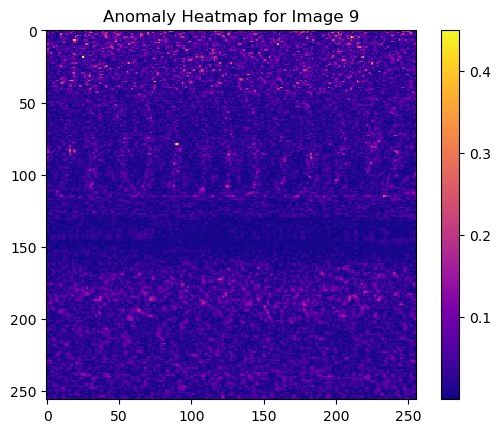

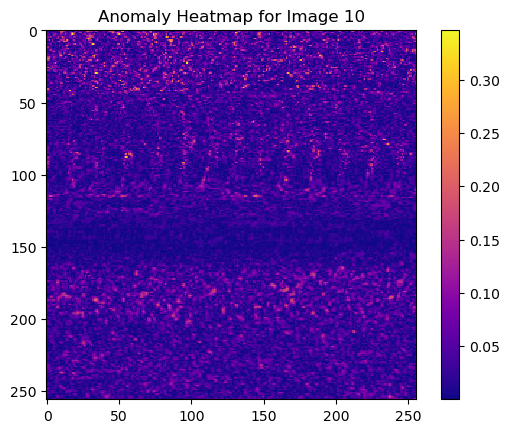

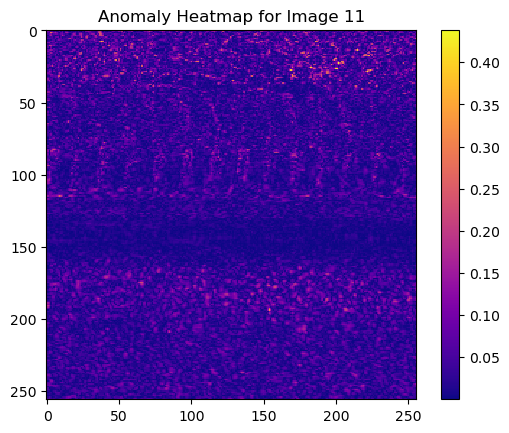

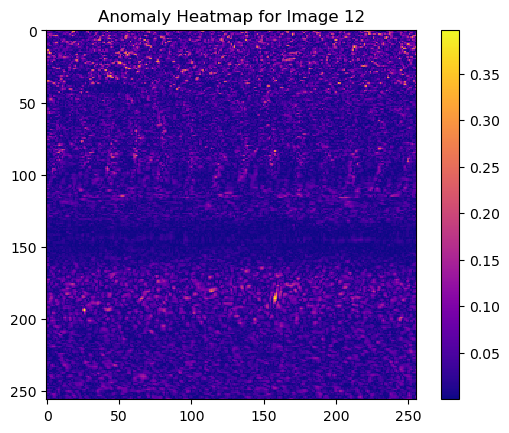

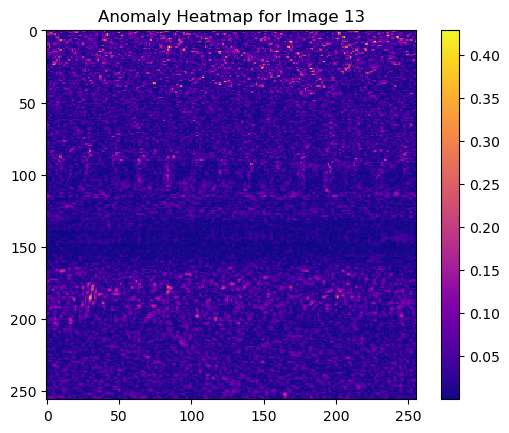

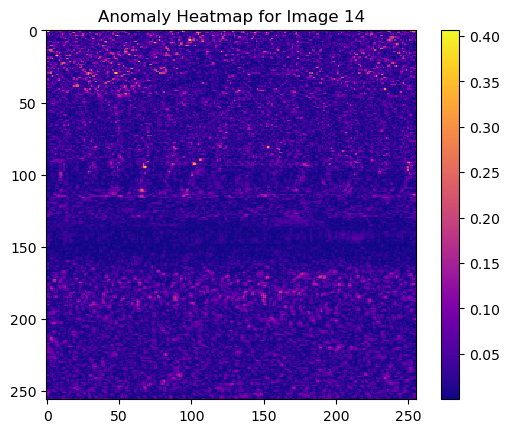

In [49]:
# Assuming original_images and reconstructed_images are your two batches
difference = torch.abs(test_batch - reconstructed_images)

# The difference tensor will have shape (14, 1, 256, 256)
def create_heatmap(diff_image):
    # Remove the channel dimension and convert to numpy
    diff_image = diff_image.squeeze(0).cpu().numpy()
    
    # Create a figure and axis
    fig, ax = plt.subplots()
    
    # Create the heatmap
    im = ax.imshow(diff_image, cmap='plasma', interpolation='nearest')
    
    # Add a colorbar
    plt.colorbar(im)
    
    return fig

# Create and display heatmaps for all 14 image pairs
for i in range(14):
    fig = create_heatmap(difference[i])
    plt.title(f'Anomaly Heatmap for Image {i+1}')
    plt.show()

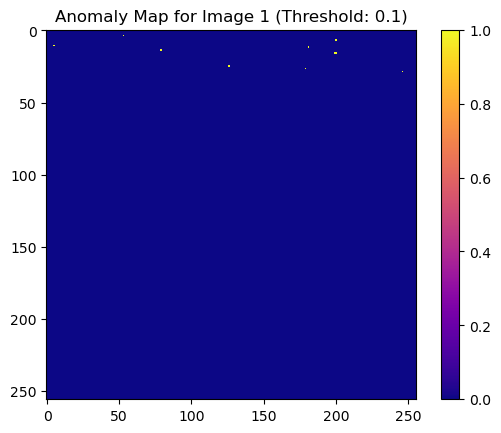

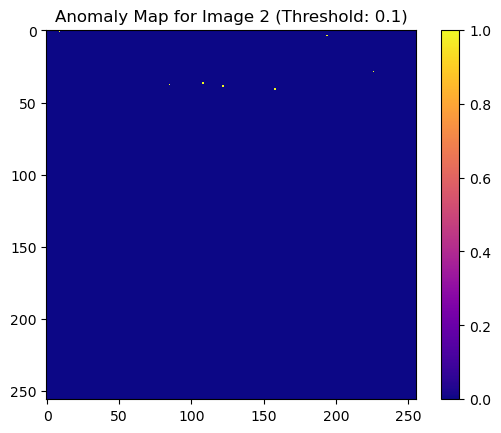

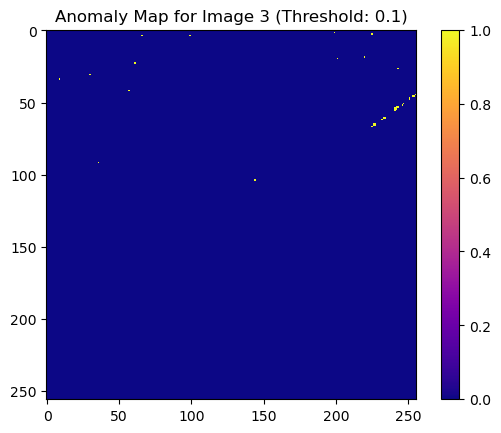

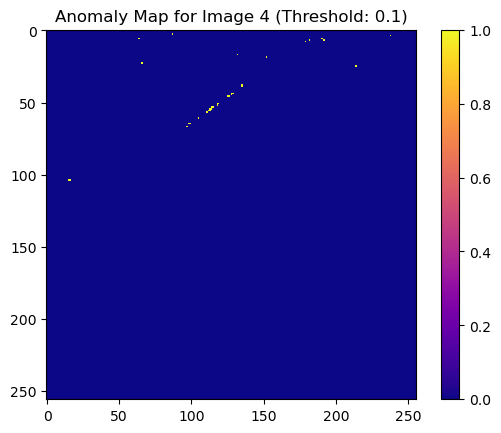

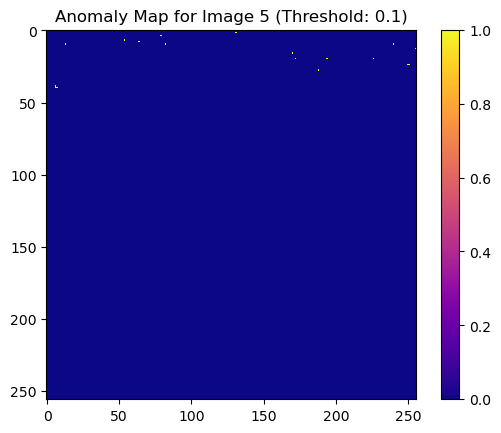

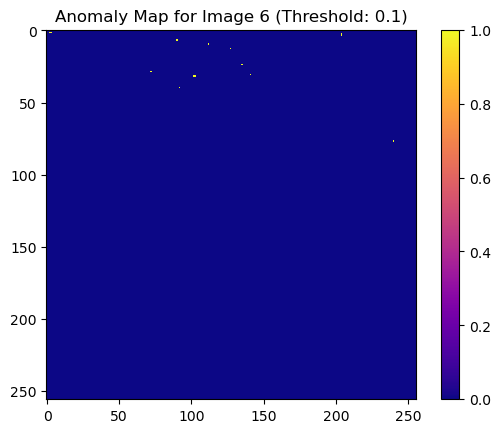

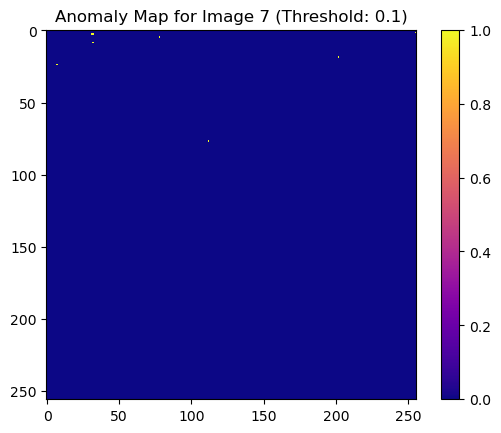

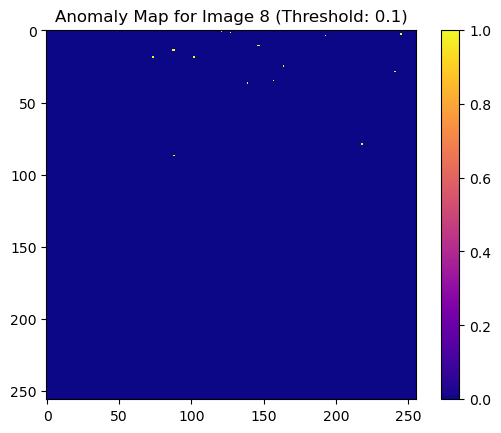

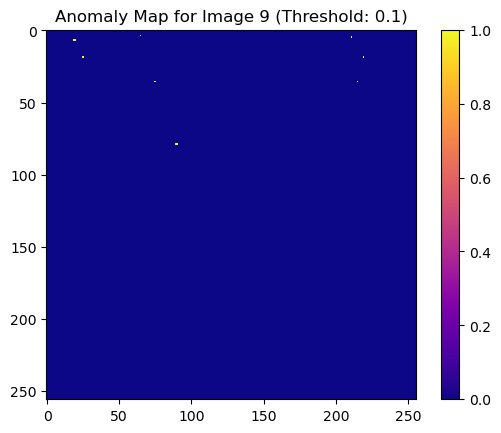

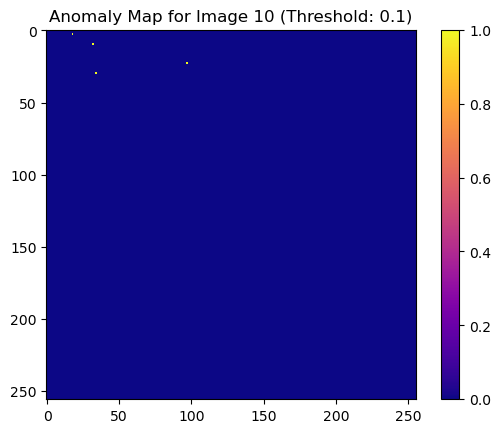

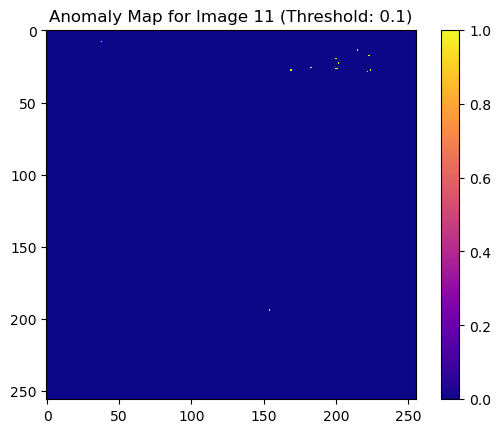

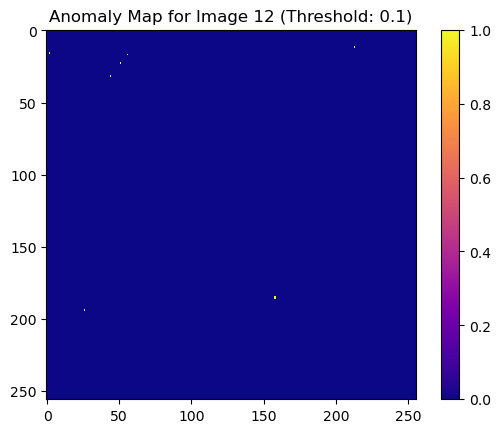

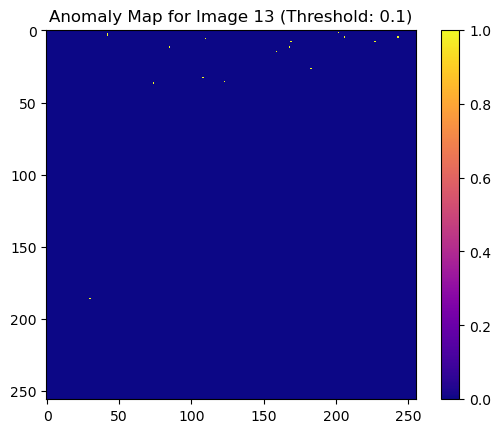

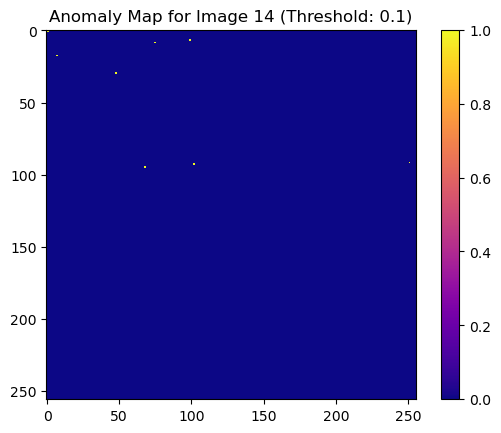

In [74]:
def detect_anomalies(diff_image, threshold):
    # Apply threshold
    anomalies = (diff_image > threshold).float()
    return anomalies

# Choose a threshold value (you may need to adjust this based on your data)
threshold = 0.1

# Detect anomalies for all images
anomaly_maps = torch.stack([detect_anomalies(diff, threshold) for diff in mse_difference])

# Create heatmaps of anomalies
for i in range(14):
    fig = create_heatmap(anomaly_maps[i])
    plt.title(f'Anomaly Map for Image {i+1} (Threshold: {threshold})')
    plt.show()

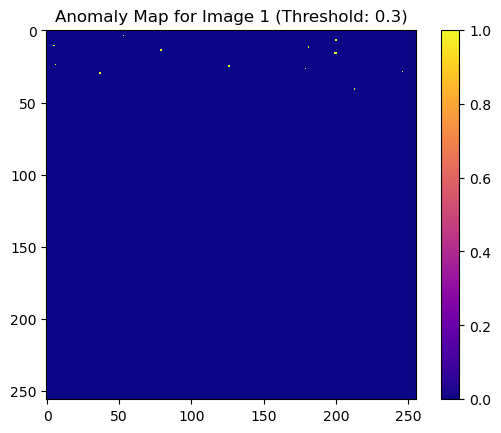

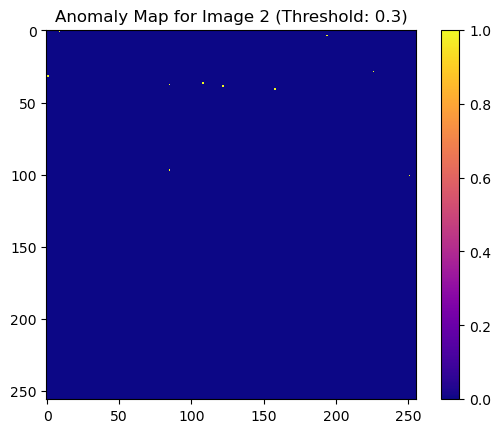

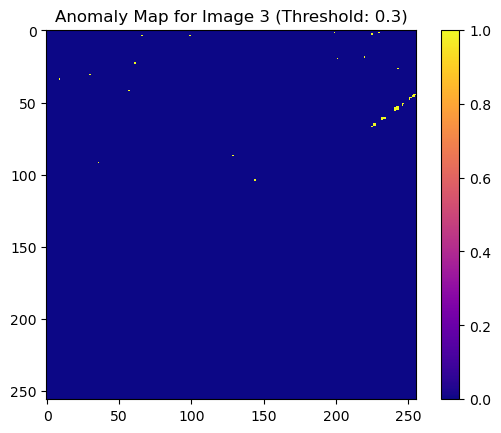

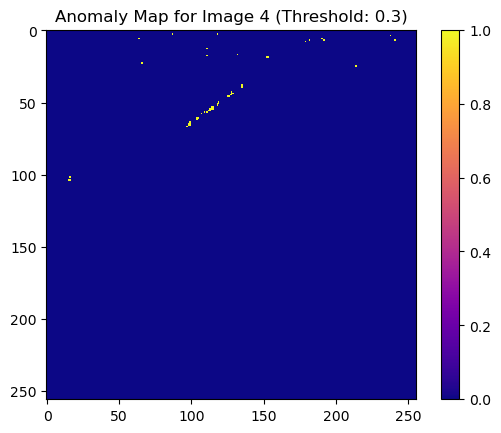

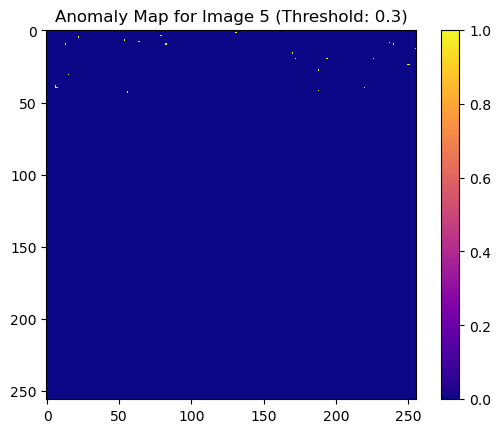

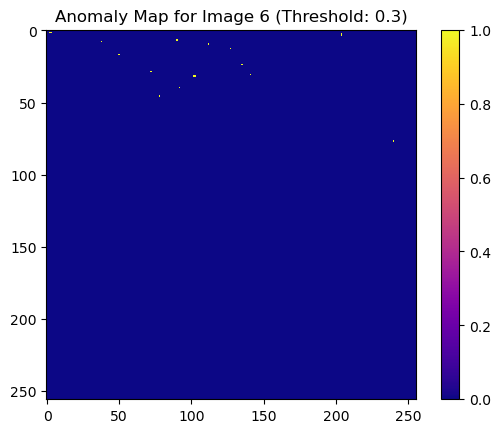

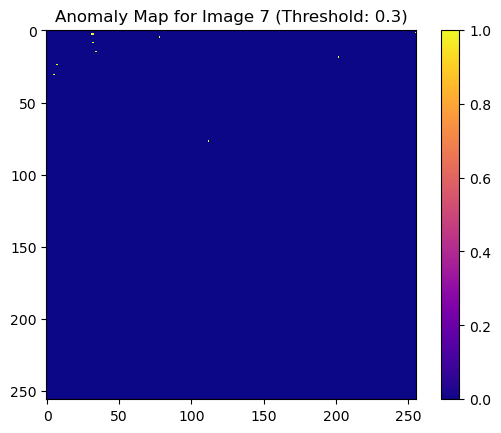

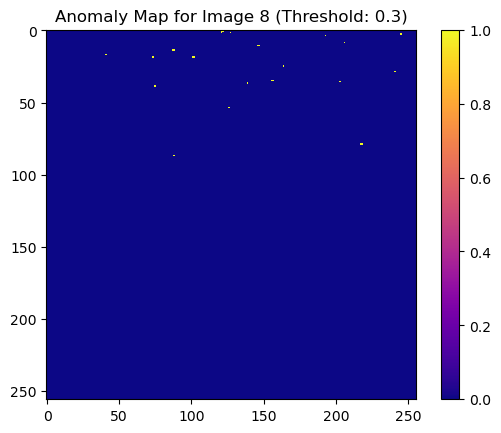

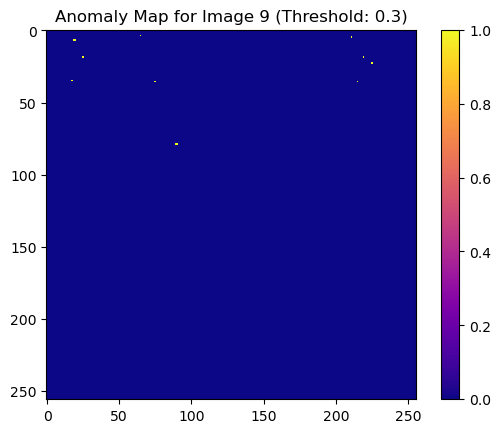

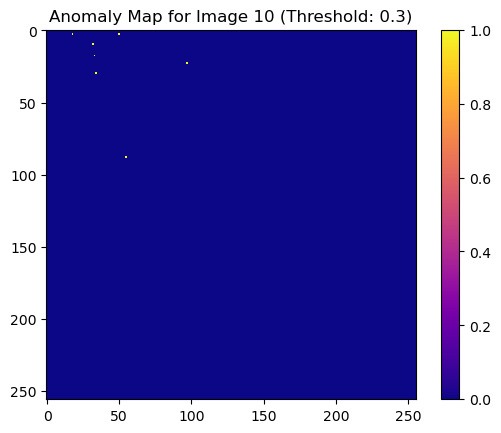

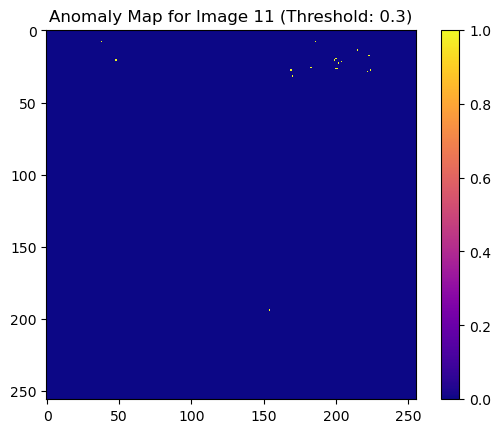

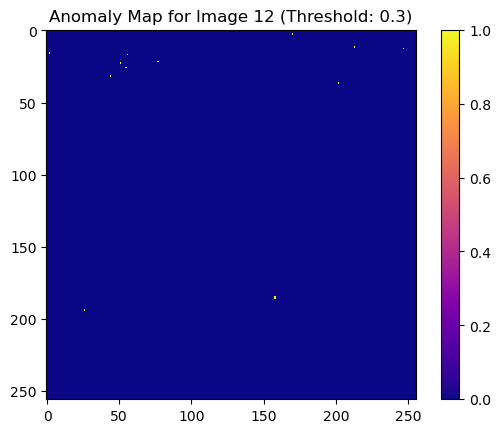

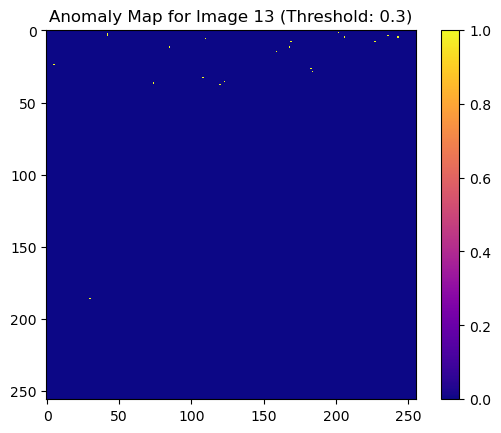

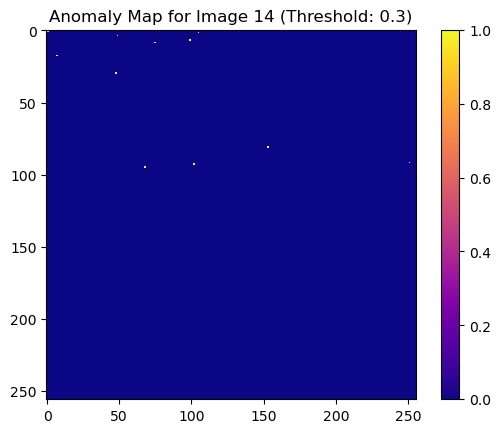

In [75]:
def detect_anomalies(diff_image, threshold):
    # Apply threshold
    anomalies = (diff_image > threshold).float()
    return anomalies

# Choose a threshold value (you may need to adjust this based on your data)
threshold = 0.3

# Detect anomalies for all images
anomaly_maps = torch.stack([detect_anomalies(diff, threshold) for diff in difference])

# Create heatmaps of anomalies
for i in range(14):
    fig = create_heatmap(anomaly_maps[i])
    plt.title(f'Anomaly Map for Image {i+1} (Threshold: {threshold})')
    plt.show()

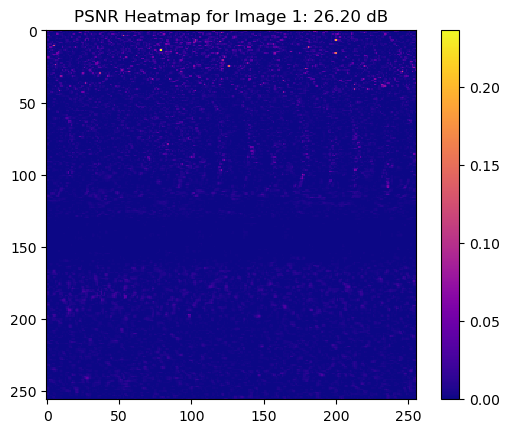

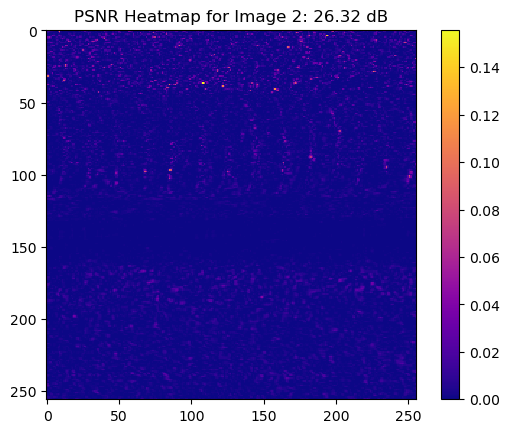

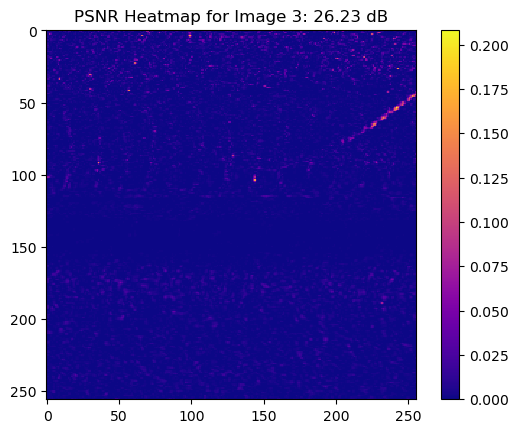

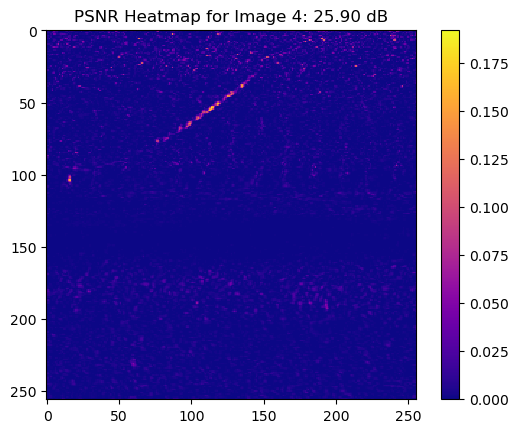

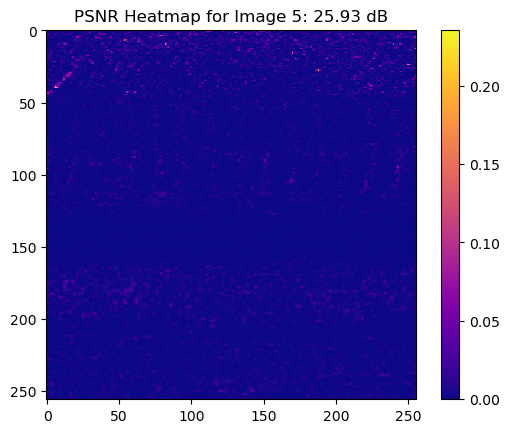

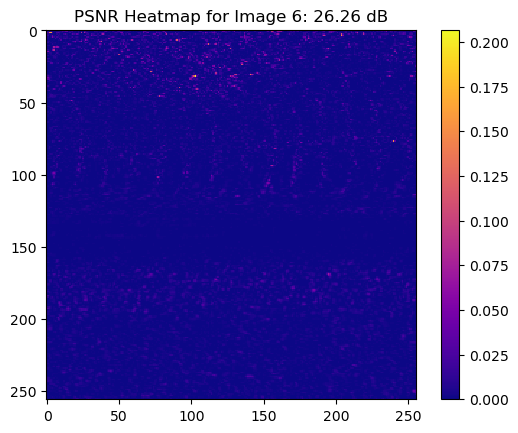

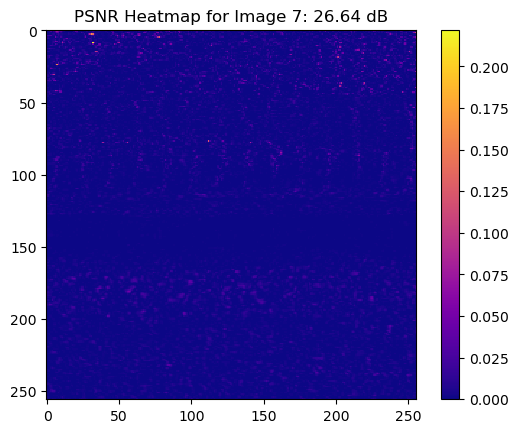

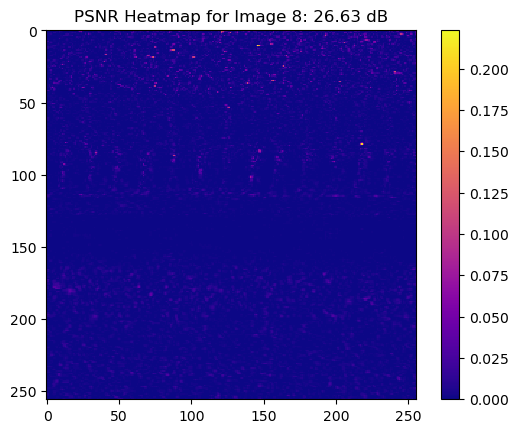

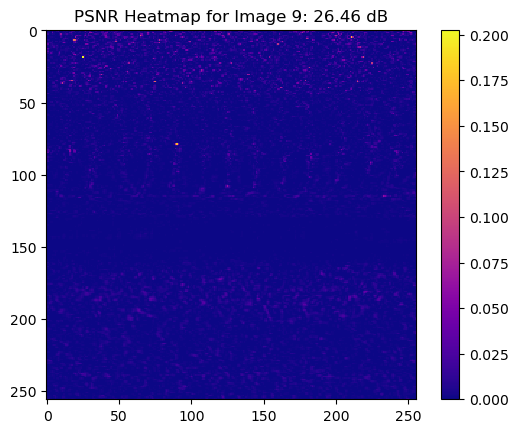

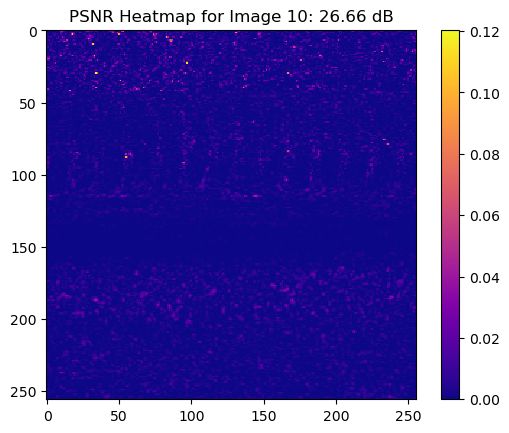

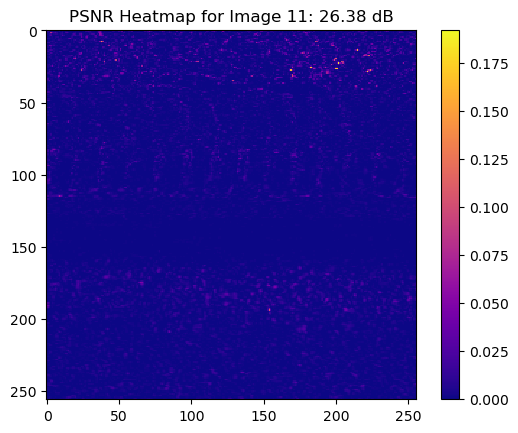

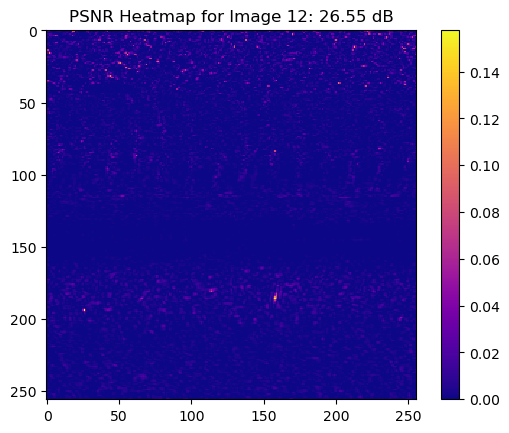

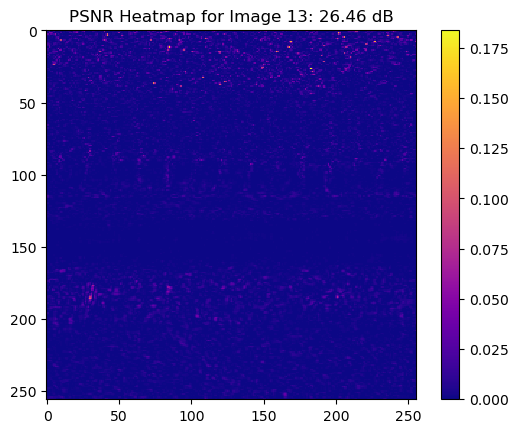

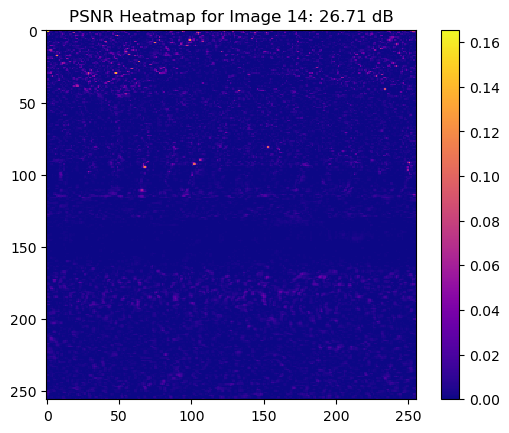

In [61]:

# Assuming test_batch and reconstructed_images are your two batches
# Compute the pixel-wise MSE (Mean Squared Error)
mse_difference = torch.square(test_batch - reconstructed_images)

# Max pixel value in the images (assuming images are normalized between 0 and 1)
max_pixel_value = 1.0

# PSNR Calculation for a single image
def psnr(mse_image, max_pixel_value=max_pixel_value):
    mse = torch.mean(mse_image)
    if mse == 0:
        return float('inf')  # If MSE is zero, return infinite PSNR (perfect reconstruction)
    psnr_value = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    return psnr_value

# The mse_difference tensor will have shape (14, 1, 256, 256)
def create_heatmap(psnr_image):
    # Remove the channel dimension and convert to numpy
    psnr_image = psnr_image.squeeze(0).cpu().numpy()
    
    # Create a figure and axis
    fig, ax = plt.subplots()
    
    # Create the heatmap
    im = ax.imshow(psnr_image, cmap='plasma', interpolation='nearest')
    
    # Add a colorbar
    plt.colorbar(im)
    
    return fig

# Create and display PSNR heatmaps for all 14 image pairs
for i in range(14):
    # Compute the PSNR for the current difference map
    psnr_image = psnr(mse_difference[i])
    
    # Create heatmap for the current PSNR map
    fig = create_heatmap(mse_difference[i])  # Visualize the MSE heatmap, since PSNR is scalar
    plt.title(f'PSNR Heatmap for Image {i+1}: {psnr_image:.2f} dB')
    plt.show()


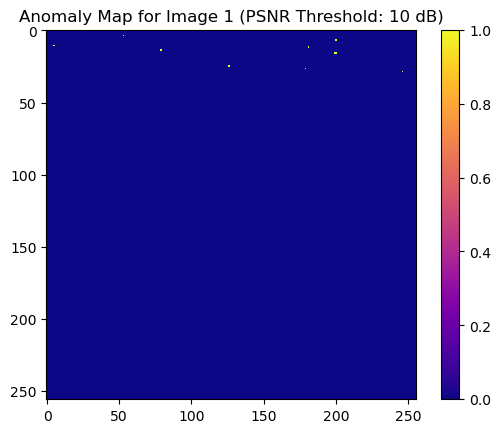

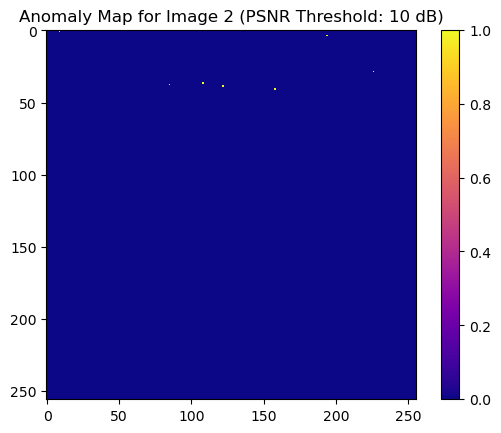

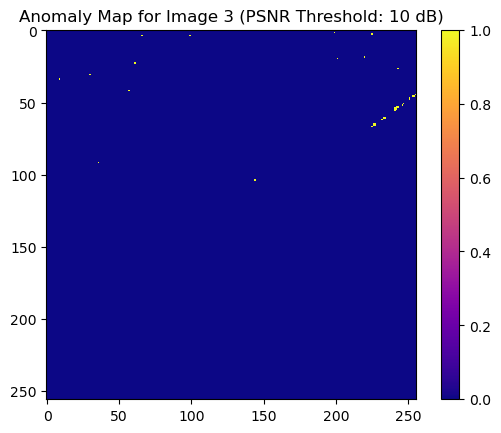

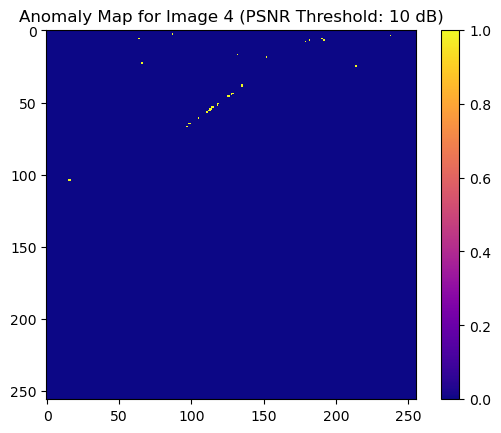

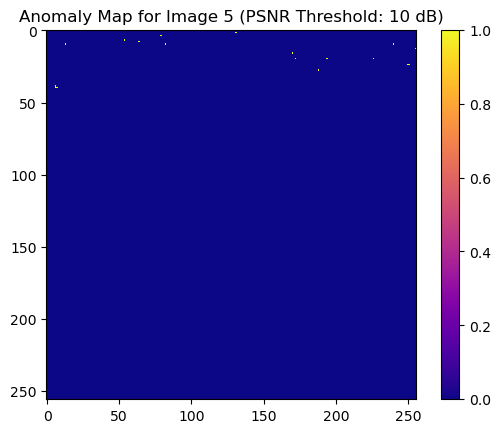

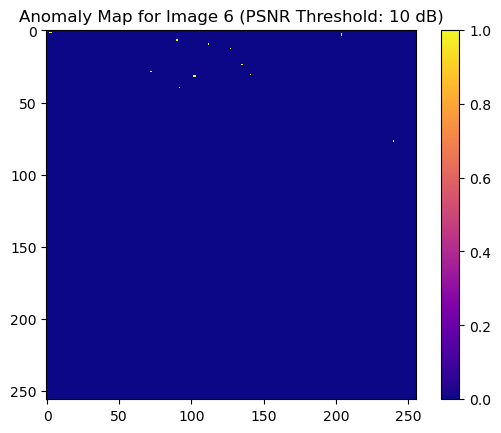

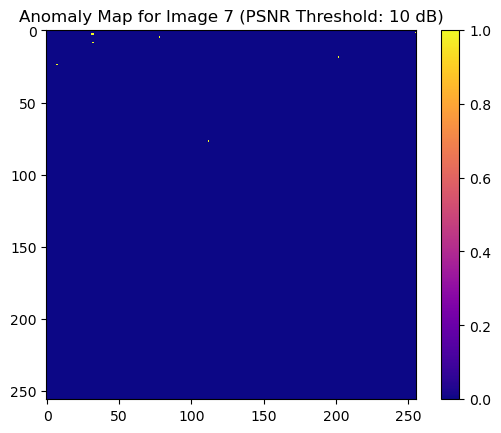

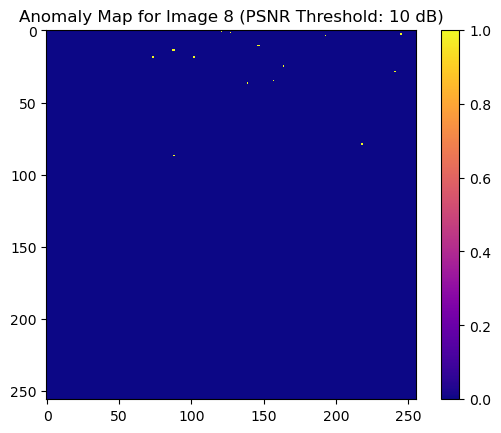

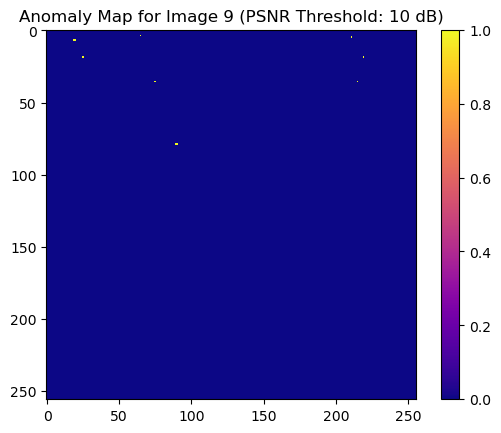

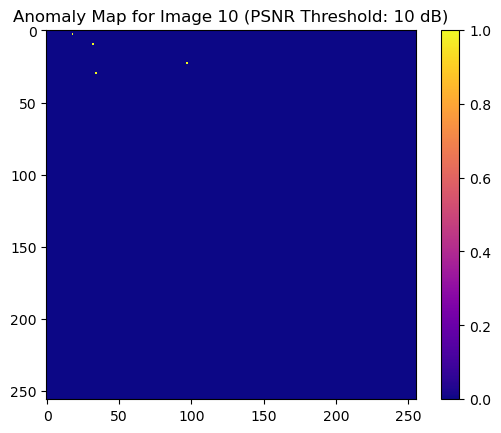

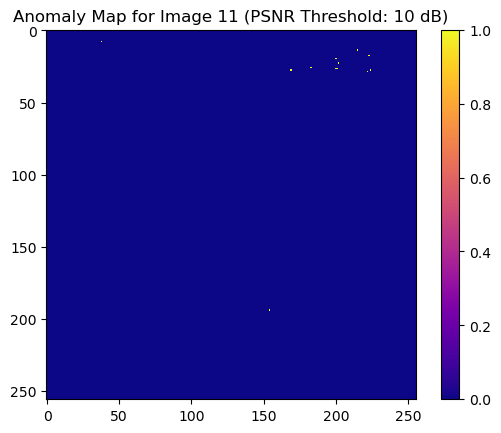

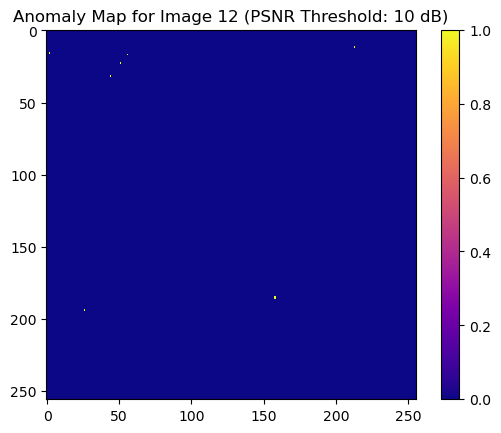

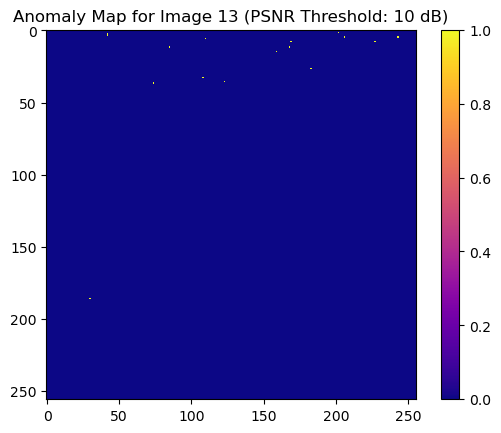

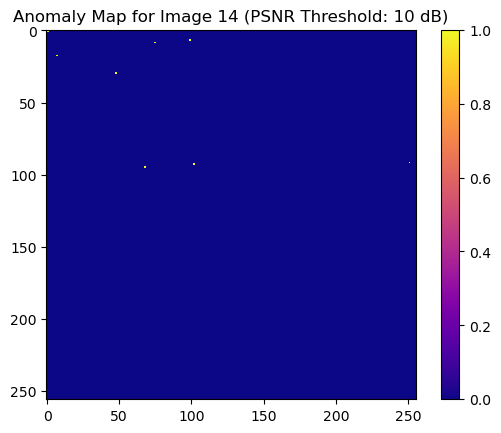

In [76]:
import torch
import numpy as np

# Max pixel value in the images (assuming images are normalized between 0 and 1)
max_pixel_value = 1.0

# Compute pixel-wise MSE (Mean Squared Error) between test_batch and reconstructed_images
mse_difference = torch.square(test_batch - reconstructed_images)

# PSNR Calculation for each pixel (based on local MSE)
def pixel_psnr(mse_image, max_pixel_value=max_pixel_value):
    psnr_image = 20 * torch.log10(max_pixel_value / torch.sqrt(mse_image + 1e-8))  # Avoid divide by zero
    return psnr_image

# PSNR threshold (you can adjust this value)
psnr_threshold = 10  # Example: set anomaly threshold at 30 dB

# Detect anomalies using PSNR
def detect_psnr_anomalies(psnr_image, psnr_threshold):
    # Apply PSNR threshold to detect anomalies (low PSNR means high anomaly)
    anomalies = (psnr_image < psnr_threshold).float()
    return anomalies

# Create PSNR maps for each image
psnr_maps = torch.stack([pixel_psnr(mse_diff) for mse_diff in mse_difference])

# Detect anomalies for each PSNR map
anomaly_maps = torch.stack([detect_psnr_anomalies(psnr_map, psnr_threshold) for psnr_map in psnr_maps])

# Create heatmaps of PSNR-based anomalies
for i in range(14):
    fig = create_heatmap(anomaly_maps[i])
    plt.title(f'Anomaly Map for Image {i+1} (PSNR Threshold: {psnr_threshold} dB)')
    plt.show()


In [73]:
import torch
import numpy as np
from skimage.metrics import structural_similarity as ssim

# Assume images are normalized between 0 and 1, so the data range is 1.0
data_range = 1.0

# Compute pixel-wise SSIM between test_batch and reconstructed_images
def pixel_ssim(original_image, reconstructed_image):
    # Convert images from torch tensors to numpy arrays (assume images are grayscale)
    original_image_np = original_image.squeeze(0).cpu().numpy()
    reconstructed_image_np = reconstructed_image.squeeze(0).cpu().numpy()
    
    # Compute SSIM for the images using the 'multichannel' option to get the SSIM map
    ssim_map, _ = ssim(original_image_np, reconstructed_image_np, data_range=data_range, full=True, multichannel=False)
    
    # Convert the SSIM map back to a torch tensor
    return torch.from_numpy(ssim_map).unsqueeze(0)  # Add back the channel dimension

# SSIM threshold (you can adjust this value)
ssim_threshold = 0.8  # SSIM values below this threshold indicate anomalies

# Detect anomalies using SSIM
def detect_ssim_anomalies(ssim_image, ssim_threshold):
    # Apply SSIM threshold to detect anomalies (low SSIM means high anomaly)
    anomalies = (ssim_image < ssim_threshold).float()
    return anomalies

# Create SSIM maps for each image
ssim_maps = torch.stack([pixel_ssim(test_batch[i], reconstructed_images[i]) for i in range(test_batch.shape[0])])

# Detect anomalies for each SSIM map
anomaly_maps = torch.stack([detect_ssim_anomalies(ssim_map, ssim_threshold) for ssim_map in ssim_maps])

# Create heatmaps of SSIM-based anomalies
for i in range(14):
    fig = create_heatmap(anomaly_maps[i])
    plt.title(f'Anomaly Map for Image {i+1} (SSIM Threshold: {ssim_threshold})')
    plt.show()



TypeError: expected np.ndarray (got numpy.float64)

In [ ]:
mse = torch.mean(difference**2, dim=(1,2,3))
print("Mean Squared Error for each image:", mse)

normalized_difference = (difference - difference.min()) / (difference.max() - difference.min())

for i in range(14):
    fig = create_heatmap(normalized_difference[i])
    plt.title(f'Normalized Anomaly Heatmap for Image {i+1}')
    plt.show()